## Observations
1. Our gradient estimates at known sample locations are large due to samples from our multioutput surrogate

In [2]:
using LinearAlgebra
using Plots

In [220]:
include("../rollout.jl")
include("../testfns.jl")

TestLinearCosine1D (generic function with 3 methods)

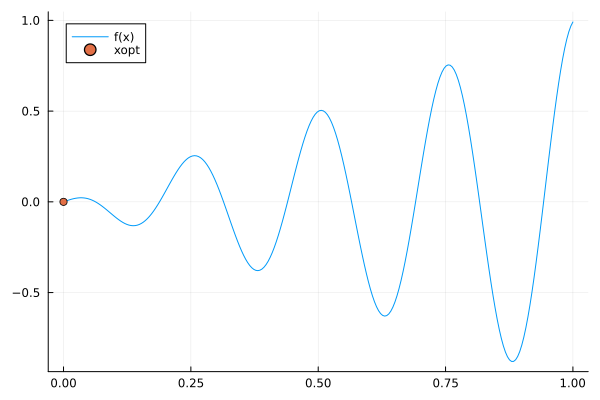

In [265]:
testfn = TestLinearCosine1D(1, 25, lb=0., ub=1)
# testfn = TestQuadratic1D(1., 0., 0.; lb=-1., ub=1.)
tplot(testfn)

In [266]:
xmin, xmax, d = (testfn.bounds[1], testfn.bounds[2], size(testfn.bounds, 1))
domain = xmin:.01:xmax
X = [0.;;]
y = [testfn.f(X[:,j]) for j in 1:size(X, 2)]
sur = fit_surrogate(ψ, X, y)

xgrads = collect(0.:.1:1.)
mofs = fit_multioutput_fsurrogate(sur, length(xgrads) - 1);
for xgrad in xgrads
    x = [xgrad]
    update_multioutput_fsurrogate!(mofs, x, testfn.f(x), testfn.∇f(x))
end

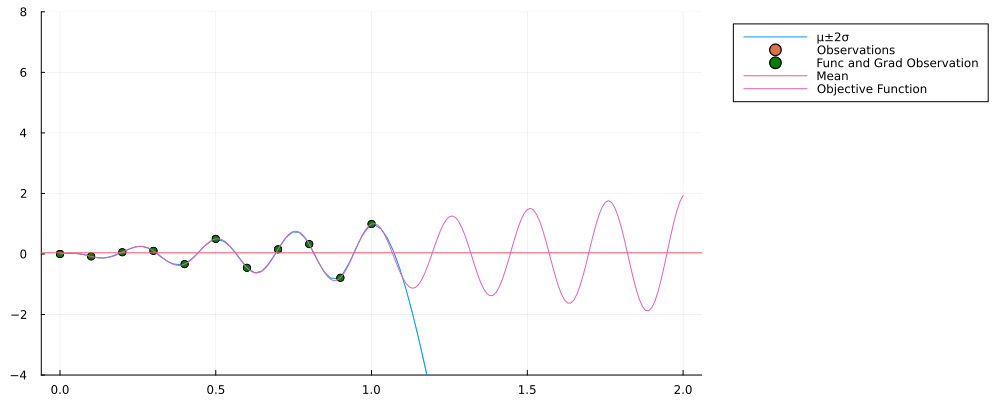

In [267]:
local_xmin = 0.
local_xmax = 2.

plot1D(mofs, xmin=local_xmin, xmax=local_xmax)
scatter!([xgrads[1]], [testfn.f([xgrads[1]])], label="Func and Grad Observation", markercolor=:green)
for i in 2:length(xgrads)
    xi = [xgrads[i]]
    scatter!(xi, [testfn.f(xi)], label=nothing, markercolor=:green)
end
hline!([mean(get_observations(mofs))], label="Mean")

udomain = local_xmin:.01:local_xmax
μs = [testfn.f(x) for x in udomain]
plot!(
    udomain, [testfn.f(x) for x in udomain],
    label="Objective Function", legend=:outertopright,
    size=(1000, 400), ylims=[-4, 8]
)

In [293]:
n, h, σn2 = 1, 1, 1e-6
MC_SAMPLES = 50
# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, h+1);
rns = randn(MC_SAMPLES, testfn.dim+1, h+1);

MAX_BUDGET, MAX_TRIALS = 25, 1
xmin, xmax, d = (testfn.bounds[1], testfn.bounds[2], size(testfn.bounds, 1))
θ = [1.]
# ψ = kernel_scale(
#     kernel_matern52,
#     [5., θ...]
# )
ψ = kernel_matern52(θ)

lbs, ubs = [xmin], [xmax]
ϵ, num_starts = 1e-6, 4
s = SobolSeq(lbs, ubs)

xstarts = reduce(hcat, next!(s) for i = 1:num_starts)
xstarts = hcat(xstarts, lbs .+ ϵ)
xstarts = hcat(xstarts, ubs .- ϵ);

### Dense Experiments in 1D for Rollout Acquisition Functions
We'll do a comparative analysis, visually, of the structure of the rollout acquisition function in 1D for horizons 0 and 1.

In [ ]:
# X = [0.;; .3;; .5;; .7;; 1.;;]
X = [.5;;]
y = [testfn.f(X[:,j]) for j in 1:size(X, 2)]
sur = fit_surrogate(ψ, X, y; σn2=σn2)
sur = optimize_hypers_optim(sur, kernel_matern52)

domain = xmin:.01:xmax

println("Minimum: $(minimum(get_observations(sur)))")
print("Beginning Experiment\nProgress Bar:\n")

B = generate_batch(16; lbs=lbs, ubs=ubs)
BUDGET = 1
w = 1e-6

rollouts = []
drollouts = []
fdrollouts = []
all_outcomes = []
each_ts = []

println("Running Bayesian Optimization...")
for budget_iteration in 1:BUDGET
    println("Step $budget_iteration.)")
    ex = zeros(length(domain))
    dex = zeros(length(domain))
    ex_stderr = zeros(length(domain))
    dex_stderr = zeros(length(domain))
    fdr = zeros(length(domain))
    
    # Dense Evaluation of Rollout Acquisition Function
    for (i, x) in enumerate(domain)
        print("|")
        x0 = [x]
        sx = sur(x0)

        tp = TrajectoryParameters(
            x0=x0, h=h, mc_iters=MC_SAMPLES,
            rnstream_sequence=rns, lbs=lbs, ubs=ubs
        )
        # Monte-carlo integrate trajectory for x0
        # μx, ∇μx, μ_stderr, ∇μ_stderr = simulate_trajectory(sur, tp, xstarts, variance_reduction=true)
        μx, ∇μx, μ_stderr, ∇μ_stderr, Ts = simulate_trajectory_deterministic(sur, tp, xstarts, testfn=testfn)
        push!(each_ts, Ts)
        ex[i] = μx
        dex[i] = first(∇μx)
        ex_stderr[i] = μ_stderr
        dex_stderr[i] = ∇μ_stderr
        
        # Finite Difference Approximation of Gradients
        tp_plus = TrajectoryParameters(
            x0=x0 .+ w, h=h, mc_iters=MC_SAMPLES,
            rnstream_sequence=rns, lbs=lbs, ubs=ubs
        )
        tp_minus = TrajectoryParameters(
            x0=x0 .- w, h=h, mc_iters=MC_SAMPLES,
            rnstream_sequence=rns, lbs=lbs, ubs=ubs
        )
        μx_plus, trash = simulate_trajectory_deterministic(sur, tp_plus, xstarts, testfn=testfn)
        μx_minus, trash = simulate_trajectory_deterministic(sur, tp_minus, xstarts, testfn=testfn)
        fdr[i] = (μx_plus - μx_minus) / 2w
    end
    push!(rollouts, ex)
    push!(drollouts, dex)
    push!(fdrollouts, fdr)
    
    
#     outcomes = []
#     # Batch Evaluation of Rollout Acquisition Function
#     for x in eachcol(B)
#         print("|")
#         x0 = convert(Vector{Float64}, x)

#         # Collect each SGA outcome
#         tp = TrajectoryParameters(x0=x0, h=h, mc_iters=MC_SAMPLES, rnstream_sequence=lds_rns, lbs=lbs, ubs=ubs)
#         outcome = stochastic_gradient_ascent_adam(λ=.01, sur=sur, tp=tp, max_sgd_iters=50, xstarts=xstarts, varred=true)
#         push!(outcomes, outcome)
#     end
#     push!(all_outcomes, outcomes)
    
#     # Find the maximizer
#     maxi, maxi_ndx = findmax(o -> o.final_obj, outcomes)
#     maxi_outcome = outcomes[maxi_ndx]
    
#     # Evaluate the original process at the maximizer
#     ynew = testfn.f(maxi_outcome.finish)
#     sur = update_surrogate(sur, maxi_outcome.finish, ynew)
#     sur = optimize_hypers_optim(sur, kernel_matern52)
#     println()
end

Minimum: 0.49889913958929033
Beginning Experiment
Progress Bar:
Running Bayesian Optimization...
Step 1.)
|||||||||||||||||||||

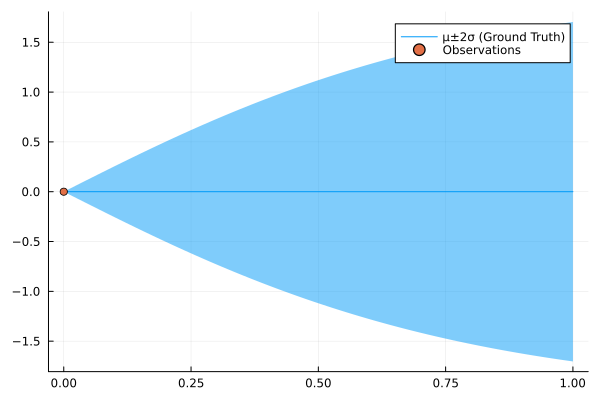

In [295]:
plot1D(sur; xmin=xmin, xmax=xmax, npts=200)

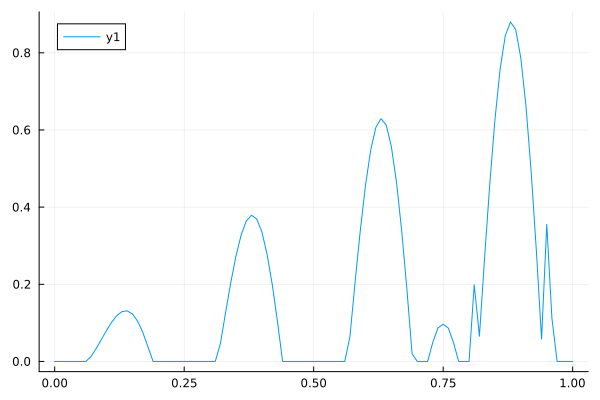

In [300]:
plot(domain, rollouts[1])

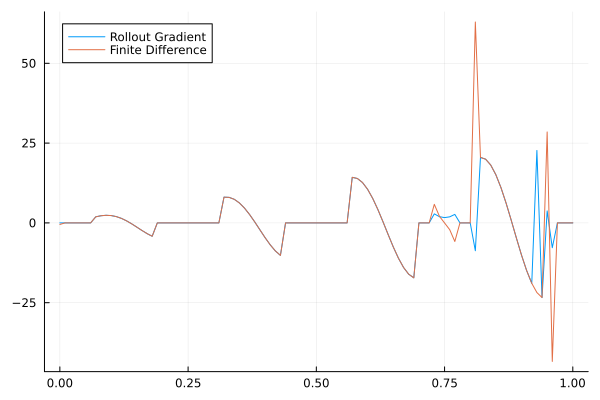

In [301]:
plot(domain, drollouts[1], label="Rollout Gradient")
plot!(domain, fdrollouts[1], label="Finite Difference")

In [292]:
each_ts[1][1].δfs.X

1×2 Matrix{Float64}:
 0.0  0.643858

In [235]:
get_observations(sur)

2-element Vector{Float64}:
 0.16000000000000003
 0.48999999999999994

In [227]:
sample(each_ts[1][1])

2-element Vector{NamedTuple{(:x, :y, :∇y), Tuple{Vector{Float64}, Float64, Vector{Float64}}}}:
 (x = [-1.0], y = 1.0, ∇y = [-2.0])
 (x = [-0.03858402067872072], y = 0.0014887266517359388, ∇y = [-0.07716804135744149])

In [131]:
iteration = 3
maxi, maxi_ndx = findmax(o -> o.final_obj, all_outcomes[iteration])
all_outcomes[iteration][maxi_ndx]

(start = [0.25], finish = [0.17081341290754865], final_obj = 0.0214089250866925, final_grad = [0.09944591752767203], iters = 7, success = true, sequence = [[0.25], [0.24000001391873105], [0.2289095304285995], [0.21654890132538826], [0.2030459928443201], [0.1877864123295147], [0.17081341290754865], [0.15654193944400888]], grads = Any[[-0.007184552996485847], [-0.05450538360480394], [-0.1921187695101247], [-0.4811606931030816], [-0.7080150942333301], [-0.5745519869853551], [0.09944591752767203]], obj = Any[2.0485048849329266e-5, 0.00028160352008720454, 0.0015824347011966701, 0.005263450368854723, 0.011883200448962974, 0.019301534545702867, 0.0214089250866925])

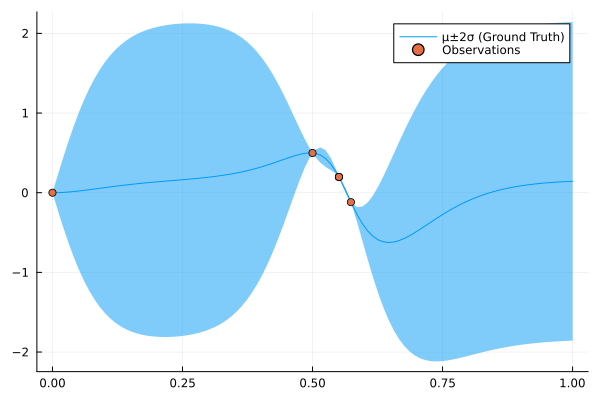

In [17]:
plot1D(sur, xmin=0.)

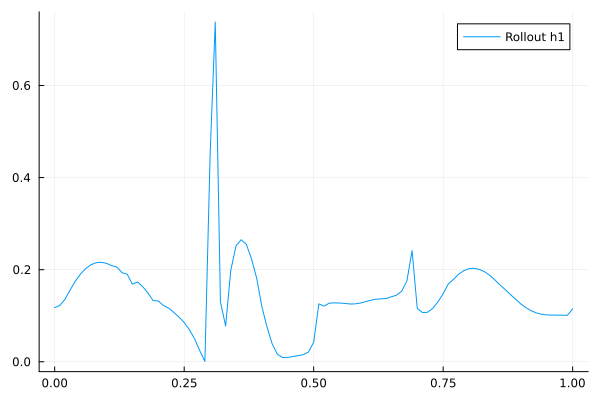

In [12]:
plot(domain, ex, label="Rollout h$h")

In [202]:
"""
TODO: We need to specify the maximum number of iterations and terminate if we exhaust our budget
TODO: EI for Rosenbrock looks like zeros everywhere, depending on how we sample. I suspect this
is why our algorithm halts here.
"""
function ei_solver(s::RBFsurrogate, lbs, ubs; initial_guesses, max_iterations=100)
    fbest = minimum(get_observations(s))

    function ei(x)
        sx = s(x)
        if sx.σ < 1e-6 return 0 end
        return -sx.EI
    end

    function ei_grad!(g, x)
        EIx = -s(x).∇EI
        for i in eachindex(EIx)
            g[i] = EIx[i]
        end
    end

    function ei_hessian!(h, x)
        HEIx = -s(x).HEI
        for row in 1:size(HEIx, 1)
            for col in 1:size(HEIx, 2)
                h[row, col] = HEIx[row, col]
            end
        end
    end

    final_minimizer = (initial_guesses[:, 1], Inf)
    
    for j in 1:size(initial_guesses, 2)
        initial_guess = initial_guesses[:, j]
        df = TwiceDifferentiable(ei, ei_grad!, ei_hessian!, initial_guess)
        dfc = TwiceDifferentiableConstraints(lbs, ubs)
        result = optimize(df, dfc, initial_guess, IPNewton(), Optim.Options(iterations=max_iterations))
        cur_minimizer, cur_minimum = Optim.minimizer(result), Optim.minimum(result)

        if cur_minimum < final_minimizer[2]
            final_minimizer = (cur_minimizer, cur_minimum)
        end
    end
    
    return final_minimizer
end

# Initialize surrogate model
Xinit = X
yinit = testfn.f.(eachcol(Xinit))
sur_ei = fit_surrogate(ψ, Xinit, yinit; σn2=σn2)

# Perform Bayesian optimization iterations
print("Budget Counter: ")
for budget in 1:BUDGET
    print("|")
    # Solve the acquisition function
    xbest, fbest = ei_solver(sur_ei, lbs, ubs; initial_guesses=xstarts)
    ybest = testfn.f(xbest)
    # Update the surrogate model
    sur_ei = update_surrogate(sur_ei, xbest, ybest)
    sur_ei = optimize_hypers_optim(sur_ei, kernel_matern52)
end

Budget Counter: 

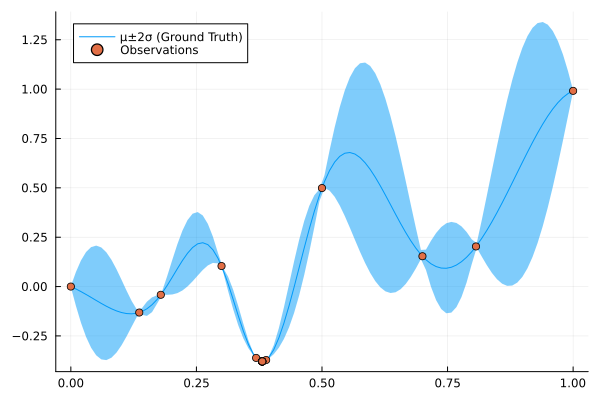

In [205]:
plot1D(sur_ei, xmin=xmin, xmax=xmax)

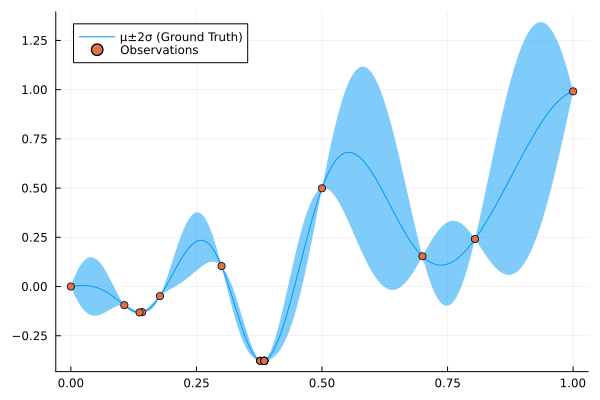

In [207]:
plot1D(sur; xmin=xmin, xmax=xmax, npts=200)